In [54]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch


from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP
from micrograd.onehot import arr2vals, oh_encode, VOID
from micrograd.eval import calc_sq_loss, calc_accuracy, evaluate
from micrograd.visualize import draw_dot

%matplotlib inline

In [55]:
np.random.seed(1337)
random.seed(1337)

CLASSES = [0, 1, 2]
oh_encoder, oh_decoder = oh_encode(CLASSES)

X = torch.tensor([
    [0.5],
])
Y_oh = oh_encoder([0])

model = MLP(
    [
        Layer(
            [X.shape[1], 1],
            'sbin',
            _lid=0
        ),
        Layer(
            [1, Y_oh.shape[1]],
            'sbin',
            init=lambda: random.choice([-1.0, 1.0]),
            _lid=1
        )
    ],
    train=True
)


X = arr2vals(X, 'input')
Y_oh = arr2vals(Y_oh, 'target')

print('inputs: ', X)
print('targets: ', Y_oh, '\n')

inputs:  [[Value(input:0:0 : [0.5, 0.0, 1.0])]]
targets:  [[Value(target:0:0 : [1.0, 0.0, 1.0]), Value(target:0:1 : [-1.0, 0.0, 1.0]), Value(target:0:2 : [-1.0, 0.0, 1.0])]] 



In [56]:
import functools

get_loss = functools.partial(calc_sq_loss, targets=Y_oh)
learner, scores, total_loss = model.make_learner(X, get_loss)


debug: X=Layer L0 of [L0:n0->sbin(1)](X)
debug: X=Layer L1 of [L1:n0->sbin(1), L1:n1->sbin(1), L1:n2->sbin(1)](X)


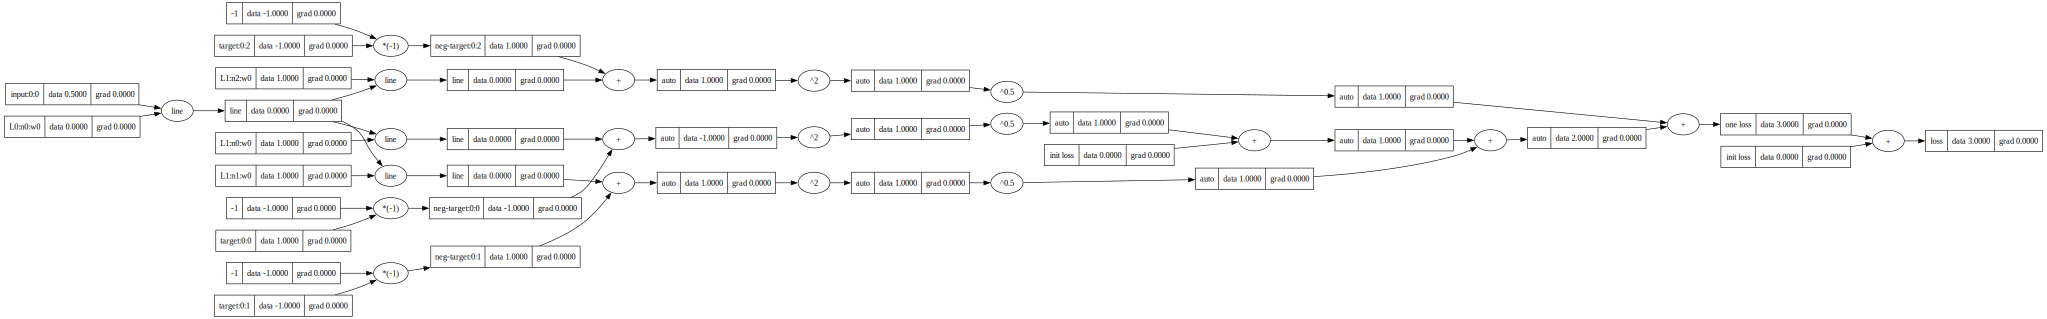

In [57]:
draw_dot(total_loss)

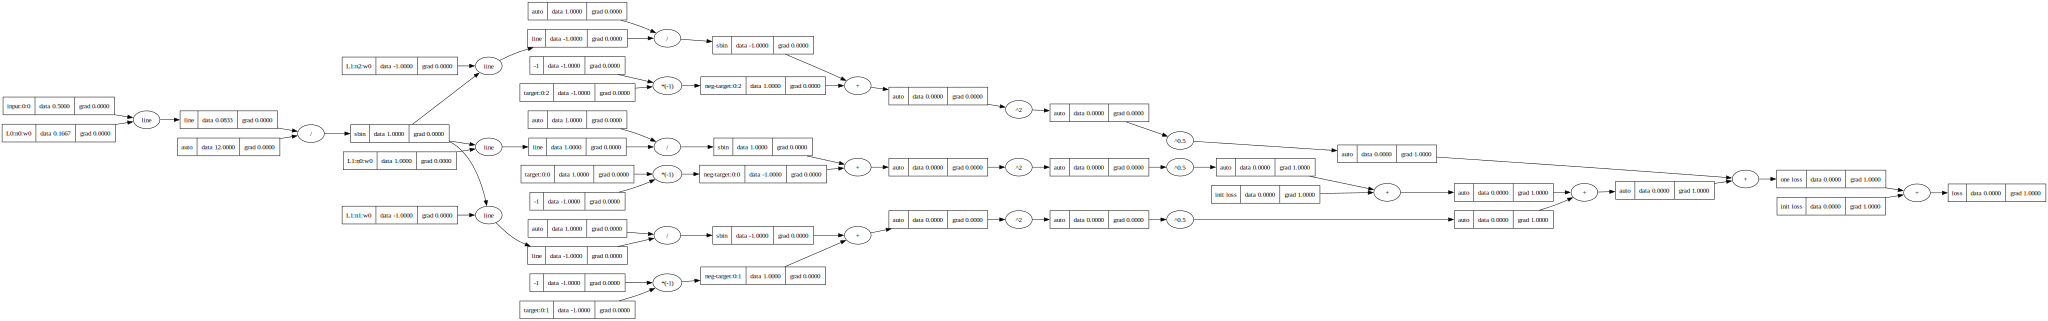

In [66]:
total_loss.backward()
draw_dot(total_loss)

In [65]:
total_loss, scores = learner(i=1, q=1.0)
total_loss, scores

0 loss: 2.0
debug: X=Layer L0 of [L0:n0->sbin(1)](X)
debug: X=Layer L1 of [L1:n0->sbin(1), L1:n1->sbin(1), L1:n2->sbin(1)](X)
final loss: 0.0


(Value(loss : [0.0, 0.0, 1.0]),
 [(Value(sbin : [1.0, 0.0, 1.0]),
   Value(sbin : [-1.0, 0.0, 1.0]),
   Value(sbin : [-1.0, 0.0, 1.0]))])

0 loss: 0.011112082062847417
debug: space =  0.0002402661678104212
debug: space =  0.0002402661678104212
1 loss: 0.00442493217220874
debug: space =  0.0002776343066913656
debug: space =  0.0002776343066913656
2 loss: 0.0033435749453181174
debug: space =  1.868406944049994e-05
debug: space =  1.868406944049994e-05
3 loss: 0.0005406786134447561
debug: space =  0.00014815918806587725
debug: space =  0.00014815918806587725
4 loss: 0.0014014481659363476
debug: space =  8.342162875313308e-05
debug: space =  8.342162875313308e-05
5 loss: 0.00047714810709442723
debug: space =  2.2386472503188592e-05
debug: space =  2.2386472503188592e-05
6 loss: 0.0003935898331293153
debug: space =  6.816283969063308e-05
debug: space =  6.816283969063308e-05
7 loss: 0.00037033658365692723
debug: space =  5.290405062813308e-05
debug: space =  5.290405062813308e-05
8 loss: 0.00024063687662567723
debug: space =  3.1324864190607205e-05
debug: space =  3.1324864190607205e-05
9 loss: 0.00020425699456771973
debug: sp

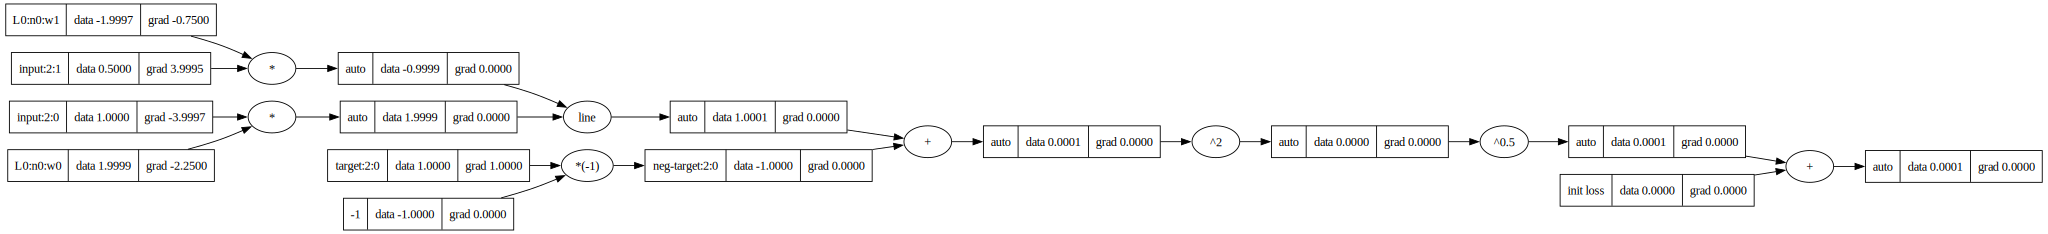

In [19]:
total_loss, scores = learner(i=10, q=0.5)
acc = calc_accuracy(scores, Y_oh, oh_decoder)
print('scores: ', scores)
print('accuracy: ', acc)
draw_dot(total_loss.child(1).child(0))

In [265]:
def learn_some(model, total_loss=None, iterations=1, logging=True, q=1.0):
    dump('start', model)

    for k in range(iterations):
        if total_loss is not None:
            model.learn_from(total_loss, logging=logging, q=q)

        scores = model(input)
        total_loss = calc_sq_loss(scores, targets)

        dump(k, model, total_loss, scores)

    acc = calc_accuracy(scores, targets, oh_decoder)
    print(f'accuracy: {acc}')


    return total_loss, scores

start params:  [Value(L0:n0:w0 : [0.0, -2.25, 1.0]), Value(L0:n0:w1 : [0.0, -0.75, 1.0]), Value(L0:n1:w0 : [0.0, 2.25, 1.0]), Value(L0:n1:w1 : [0.0, 0.75, 1.0])]
backward:loss:[grad <- 1]
backward:one loss:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 0.5]
backward:auto:[grad <- 1.0]
backward:neg-target:2:1:[grad <- 1.0]
backward:-1:[grad <- -1.0]
backward:target:2:1:[grad <- -1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 0.5]
backward:auto:[grad <- -1.0]
backward:neg-target:2:0:[grad <- -1.0]
backward:-1:[grad <- -1.0]
backward:target:2:0:[grad <- 1.0]
backward:auto:[grad <- -1.0]
backward:auto:[grad <- -1.0]
backward:input:2:1:[grad <- 0.0]
backward:auto:[grad <- -1.0]
backward:input:2:0:[grad <- 0.0]
backward:init loss:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:one loss:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 0.

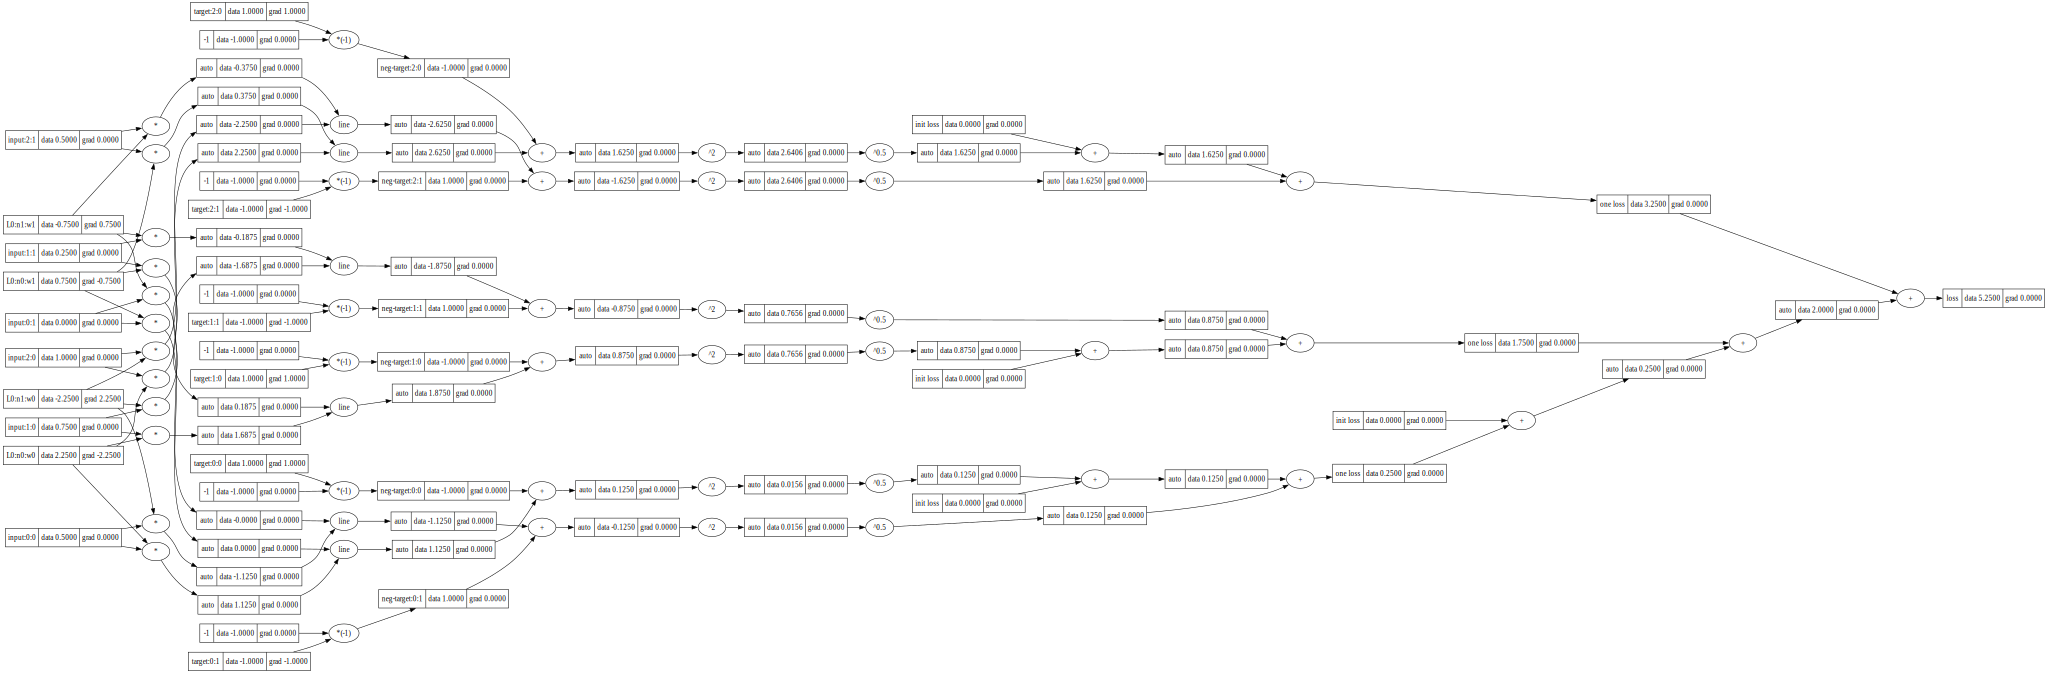

In [266]:
total_loss, scores = learn_some(model, total_loss)
draw_dot(total_loss)

debug: space =  0.75
debug: space =  0.75
backward:loss:[grad <- 1]
backward:one loss:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 0.3076923076923077]
backward:auto:[grad <- -1.0]
backward:neg-target:2:1:[grad <- -1.0]
backward:-1:[grad <- 1.0]
backward:target:2:1:[grad <- 1.0]
backward:auto:[grad <- -1.0]
backward:auto:[grad <- -1.0]
backward:auto:[grad <- -1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 0.3076923076923077]
backward:auto:[grad <- 1.0]
backward:neg-target:2:0:[grad <- 1.0]
backward:-1:[grad <- 1.0]
backward:target:2:0:[grad <- -1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:input:2:1:[grad <- 1.5]
backward:auto:[grad <- 1.0]
backward:input:2:0:[grad <- 4.5]
backward:init loss:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:one loss:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 0.5714285714285714]
backward:auto:[grad <- -1.0]
backward:neg-target:1:1:[grad <- -1.0]
backwa

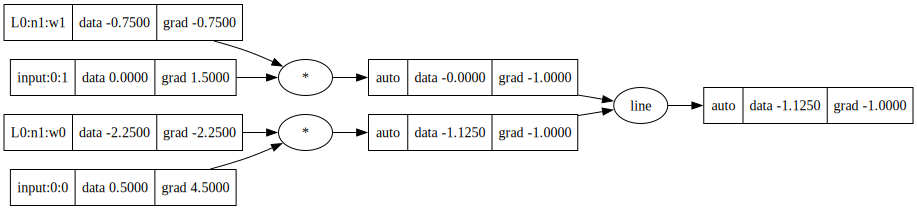

In [267]:
scores = model(input)
total_loss = calc_sq_loss(scores, targets)
total_loss.backward(logging=True)
print(f'loss: {total_loss.data}')
draw_dot(scores[0][1])

start params:  [Value(L0:n0:w0 : [0.0, 2.25, 1.0]), Value(L0:n0:w1 : [0.0, 0.75, 1.0]), Value(L0:n1:w0 : [0.0, -2.25, 1.0]), Value(L0:n1:w1 : [0.0, -0.75, 1.0])]
debug: space =  0.75
debug: space =  0.75
0 params:  [Value(L0:n0:w0 : [2.25, -2.25, 1.0]), Value(L0:n0:w1 : [0.75, -0.75, 1.0]), Value(L0:n1:w0 : [-2.25, 2.25, 1.0]), Value(L0:n1:w1 : [-0.75, 0.75, 1.0])]
0 loss:  Value(loss : [5.25, 0.0, 1.0])
0 scores:  [(Value(auto : [1.125, 0.0, 1.0]), Value(auto : [-1.125, 0.0, 1.0])), (Value(auto : [1.875, 0.0, 1.0]), Value(auto : [-1.875, 0.0, 1.0])), (Value(auto : [2.625, 0.0, 1.0]), Value(auto : [-2.625, 0.0, 1.0]))] 

accuracy: 0.3333333333333333


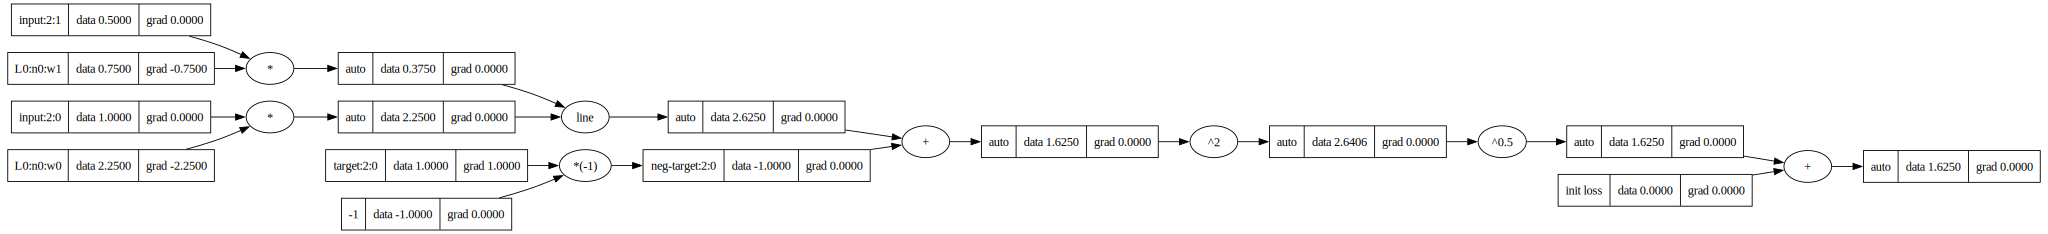

In [297]:
total_loss, scores = learn_some(model, total_loss, 1, q=1.0, logging=False)
draw_dot(total_loss.child(1).child(0))